In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
from matplotlib import animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
from scipy.optimize import curve_fit
import matplotlib.pylab as pylab
from scipy.stats import iqr
from scipy import io as sio
from matplotlib.colors import LinearSegmentedColormap


In [2]:
""" Imports. matplotlib and cv2 for visualization, numpy and random for the engine, scipy for analysis"""

#import numpy as np
#from matplotlib import pyplot as plt
#import cv2
#import random
#from matplotlib import animation
#from matplotlib.animation import FuncAnimation
#%matplotlib inline
#from scipy.optimize import curve_fit
#import matplotlib.pylab as pylab
L=1000

#define function for periodic boundary conditions
def pb(x0,L):
	return((x0+L)%L)


#Define the ant class
class ant():
    """Ant class defines how individual cars will behave. There are several attributes and methods:
        
        attributes:
            x = position on road of length L (initialized to a random number)
            y = which lane (e.g. for three lane simulation y = 0, 1, or 2)
            xunp = total distance traveled (useful for generating space-time plots)
            v = current velocity of the car (initialized to a small random value)
            v_pref = preferred velocity of a car (on average this will be 29 m/s or ~65 mph)
            R = distance corresponding to "two second rule". At separations less than R, cars don't feel each other
            r = size of a car
            ids = an i.d. number for the car
            stopped = a boolean to determine whether the car is "broken down" or behaving normally
            idm = an option to model the car's behavior using the Intelligent Driver Model (see wikipedia)
            idmT, idmA, idmB, idmDelta = parameters for the intelligent driver model
            flowc = a parameter that can set cars to 'stopped'
            dt = the size of a simulation time-step
            
        methods:
            step(d, vbar, counter, delV):
                this method evolves the car by one time-step. updates vbar, xunp, and x.
                Inputs are...
                d = distance to next car
                delV = speed difference between this car and car in front of it
                counter = just a counter to keep track of how many timesteps have elapsed
                vbar = the average velocity of all cars in the simulation. During this car's
                    update, the average velocity of all cars will be updated
            force(x, delV):
                this method computes the current force on the car, passes output to step()
                Inputs are...
                x = distance to next car
                delV = speed difference w/r/t next car
                
    """
    
    def __init__(self,ids,y=0,flowc=0,stoppedc=0,cari=0):
        col=['ro','bo','go']
        self.x=np.random.uniform(0,L)
        self.y=y
        self.xunp=self.x
        self.v=np.random.uniform(0,1)
        #self.tau=.1
        self.dt=.1
        self.v_pref=33.33#+np.random.normal(0,6.7/2)
        #self.R=29*2
        self.r=5
        self.ids=ids
        self.idmT=1.6
        self.idmA=0.73
        self.idmB=1.67
        self.idmDelta=4
        self.stopped=0
        self.laneint=col[y]
        #print(cari)
        if (cari>=flowc):   
            #print(cari)
            self.v_pref=0  
            self.v=0
            self.stopped=1
                #print(stoppedc)

              
    def step(self,d=None,vbar=0,counter=0,delV=0):
        if d==None:
            self.xunp=self.xunp+self.dt*self.v
            self.x=pb(self.x+self.dt*self.v,L)
            return('same')
        else:
            if d<=0:
                f=0
            else:
                #if d<self.R:
                    #ep=((self.v_pref)/self.tau)*(1-(self.r/self.R))**(-1.5)
                f=self.force(d,delV)
                #else:
                #    f=0
        x0=self.x
        self.v=max(0,self.v+self.dt*f)
        counter+=1 
        vbar=((counter-1)*vbar+self.v)/counter
        self.xunp=self.xunp+self.dt*self.v
        self.x=pb(self.x+self.dt*self.v,L)
        return(vbar,counter)
    def force(self,x,delV=0):
        if self.v_pref==0:
            return(0)
        s_star=2+max(0,self.idmT*self.v+(self.v*delV)/((self.idmA*self.idmB)**.5))
        f=self.idmA*(1-(self.v/self.v_pref)**self.idmDelta-(s_star/(x-self.r))**2)
        return(f)
        
        if type(f)!=complex:
            return(f)
        else:
            return(0)

        
class ants():
    def __init__(self,num_ants=20,lanes=3,L=1000,flowc=0,stoppedc=0,politeness=1):
        self.lanes=lanes
        self.num_ants=num_ants
        #self.stopped=stoppedc
        self.members=[[] for i in range(lanes)]
        self.state=[[] for i in range(lanes)]
        self.vel=[[] for i in range(lanes)]
        self.ids=[[] for i in range(lanes)]
        self.xunp=[[] for i in range(lanes)]
        self.stopped=[[] for i in range(lanes)]
        self.laneint=[[] for i in range(lanes)]
        self.L=L
        self.p=politeness
        #self.idm=idm
        cari=0
        #meanvel=0
        for l in range(lanes):
            self.members[l]=[ant(ids=i,y=l,flowc=flowc,stoppedc=stoppedc,cari=i) for i in range(num_ants)]
            self.state[l]=np.array([bug.x for bug in self.members[l]])
            self.xunp[l]=np.array([bug.xunp for bug in self.members[l]])
            self.vel[l]=np.array([bug.v for bug in self.members[l]])
            self.stopped[l]=np.array([bug.stopped for bug in self.members[l]])
            self.ids[l]=np.array([i for i in range(num_ants)])
            self.members[l]=sorted(self.members[l], key=lambda bug: bug.x)
            self.laneint[l]=np.array([bug.laneint for bug in self.members[l]])
            self.counter=0
            self.vbar=0
            
            
    def step(self):
        meanvel=0
        to_switch=[[] for i in range(self.lanes)]
        for l in range(self.lanes):
        #l=np.random.choice([0,1,2])
        #a1=np.arange(len(self.members[l]))
        #random.shuffle(a1)
        
            for i in range(len(self.members[l])):
                bug=self.members[l][i]
                switchQ=False
                if bug.y==0:
                    if random.random()>.5:
                        switchQ=self.change_lanesQ(0,1,bug,i)
                    if switchQ:
                        to_switch[1].append(bug)
                elif bug.y==1:
                    lane_to_try=np.random.choice([0,2])
                    switchQ=self.change_lanesQ(1,lane_to_try,bug,i)
                    #switchQ=self.change_lanesQ(1,0,bug,a1[i])
                    if(switchQ):
                        to_switch[lane_to_try].append(bug)
                else:
                    if random.random()>.5:
                        switchQ=self.change_lanesQ(2,1,bug,i)
                    if switchQ:
                        to_switch[1].append(bug)
            
                x_b=pb(bug.x,self.L); v_b=bug.v
                x_ol=pb(self.members[l][pb(i+1,len(self.members[l]))].x,self.L)
                v_ol=self.members[l][pb(i+1,len(self.members[l]))].v
                dx_b=min(abs(x_ol-x_b),self.L-abs(x_ol-x_b))
                delV_b=-v_ol+v_b                
                if((dx_b>7) and (bug.stopped==0)):
                    self.vbar,self.counter=bug.step(dx_b,self.vbar,self.counter,delV=delV_b)
                elif (dx_b<=7):
                #
                    bug.v=0
                               
            
        for l in range(self.lanes):
            for bug in to_switch[l]:
                self.members[l].append(bug)
                self.members[bug.y].remove(bug)
                bug.y=l
        for l in range(self.lanes):
                
            self.members[l]=sorted(self.members[l],key=lambda y: y.x)
            self.state[l]=np.array([bug.x for bug in self.members[l]])
            self.xunp[l]=np.array([bug.xunp for bug in self.members[l]])
            self.vel[l]=np.array([bug.v for bug in self.members[l]])
            self.ids[l]=np.array([bug.ids for bug in self.members[l]])
            self.stopped[l]=np.array([bug.stopped for bug in self.members[l]])
            meanvel=meanvel+np.mean(self.vel[l])
            
        meanvel=meanvel/3
 
        return(meanvel)
												
    def change_lanesQ(self,current_lane,new_lane,bug,i):
        nf_index=self.find_neighbor(bug,new_lane) 
        x_b=pb(bug.x,self.L)
        v_b=bug.v
        x_nl=pb(self.members[new_lane][pb(nf_index+1,len(self.members[new_lane]))].x,self.L)
        v_nl=self.members[new_lane][pb(nf_index+1,len(self.members[new_lane]))].v
        x_nf=pb(self.members[new_lane][nf_index].x,self.L)
        v_nf=self.members[new_lane][nf_index].v
        x_ol=pb(self.members[current_lane][pb(i+1,len(self.members[current_lane]))].x,self.L)
        v_ol=self.members[current_lane][pb(i+1,len(self.members[current_lane]))].v
        x_of=pb(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].x,self.L)
        v_of=self.members[current_lane][pb(i-1,len(self.members[current_lane]))].v

        #2) get relevant dx values
        #    a) get the current values
        dx_nf=min(abs(x_nl-x_nf),self.L-abs(x_nl-x_nf))
        dx_b=min(abs(x_ol-x_b),self.L-abs(x_ol-x_b))
        dx_of=min(abs(x_b-x_of),self.L-abs(x_b-x_of))
        #    b) get the values after the lane switch
        dx_bp=min(abs(x_nl-x_b),self.L-abs(x_nl-x_b))
        dx_nfp=min(abs(x_b-x_nf),self.L-abs(x_b-x_nf))
        dx_ofp=min(abs(x_ol-x_of),self.L-abs(x_ol-x_of))
        
        #get relevant delv values
        dv_nf=-v_nl+v_nf
        dv_b=-v_ol+v_b
        dv_of=-v_b+v_of
        
        dv_bp=-v_nl+v_b
        dv_nfp=-v_b+v_nf
        dv_ofp=-v_ol+v_of
        
        #3) get relevant forces
        f_current=[bug.force(dx_b,dv_b)]
        f_current.append(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].force(dx_of,dv_of))
        f_current.append(self.members[new_lane][nf_index].force(dx_nf,dv_nf))
        
        f_new=[bug.force(dx_bp,dv_bp)]
        f_new.append(self.members[new_lane][nf_index].force(dx_nfp,dv_nfp))
        f_new.append(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].force(dx_ofp,dv_ofp))
        if ((f_current[0]+self.p*(f_current[1]+f_current[2])<1*(f_new[0]+self.p*(f_new[1]+f_new[2]))) and \
            (bug.stopped==0) and (dx_nfp>7) and (dx_bp>7)):
            return(True)
        return(False)
								
    def view(self,t):
        fig=plt.figure()
        plt.xlim(-1,self.L+1)
        plt.ylim(-1,2)
        line1, =plt.plot(np.arange(self.L),np.zeros(self.L),'k')
        a1='ro'
        #line2, =plt.plot([b.x for b in self.members[0]],np.zeros(len(self.members[0])),'ro')            
        line3, =plt.plot(np.arange(self.L),.5*np.ones(self.L),'k')
        #line4, =plt.plot([b.x for b in self.members[1]],.5*np.ones(len(self.members[1])),'bo')
        line5, =plt.plot(np.arange(self.L),np.ones(self.L),'k')
        #line6, =plt.plot([b.x for b in self.members[2]],np.ones(len(self.members[2])),'go')
        for l in range(0,3):
            for b in self.members[l]:
                plt.plot(b.x,np.array([1])*.5*l,b.laneint)
                if(b.stopped==1):
                    plt.plot(b.x,np.array([1])*.5*l,'ko')
        
        
        fig.savefig('./images/graph'+str(t)+'.png') #save figures
        plt.close(fig)
        
    def find_neighbor(self,bug,new_lane):
        x=0;i=0
        while(x<bug.x):
            try:
                x=self.members[new_lane][i].x
            except IndexError:
                return(i-1)
            i+=1
        return(i-2)
        
    def video(self,n_steps=20):
        fig=plt.figure(figsize=(10,3))
        plt.xlim(-1,self.L+1)
        plt.ylim(-2,2)
        line1, =plt.plot(np.arange(self.L),np.zeros(self.L),'k')
        line2, =plt.plot([b.x for b in self.members[0]],np.zeros(len(self.members[0])),'ro')
        line3, =plt.plot(np.arange(self.L),np.ones(self.L),'k')
        line4, =plt.plot([b.x for b in self.members[1]],np.ones(len(self.members[1])),'bo')
        line5, =plt.plot(np.arange(self.L),-np.ones(self.L),'k')
        line6, =plt.plot([b.x for b in self.members[0]],-np.ones(len(self.members[0])),'go')
        while(True):
            for i in range(n_steps):
                self.step()
            line2.set_xdata([b.x for b in self.members[0]])
            line2.set_ydata(np.zeros(len(self.members[0])))
            line4.set_xdata([b.x for b in self.members[1]])
            line4.set_ydata(np.ones(len(self.members[1])))
            line6.set_xdata([b.x for b in self.members[2]])
            line6.set_ydata([-np.ones(len(self.members[2]))])
            fig.canvas.draw()
            img=np.fromstring(fig.canvas.tostring_rgb(),dtype=np.uint8,sep='')
            img=img.reshape(fig.canvas.get_width_height()[::-1]+(3,))
            img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
            cv2.imshow('ants',img)
            if cv2.waitKey(20)==27:
                break
        cv2.destroyWindow('ants')


#%%
def run(flux,c):

#	print(nc[k],ac[j])
#dens2=np.zeros(10000)
#phi2=np.zeros(10000)
	for t in range(10000):
		d1=0
		f1=0
		av1=0
		meanv=my_ants.step()
		if (t>=5000):
			p=my_ants.state
			p=np.r_[p[0],p[1],p[2]]
			v=my_ants.vel                
			v=np.r_[v[0],v[1],v[2]]
			stop=my_ants.stopped                
			stop=np.r_[stop[0],stop[1],stop[2]]
			w=np.where((p>250) & (p<750))[0]   
			d1=d1+len(w)                
			f1=f1+np.sum(v[w])  
#				print(len(v),len(stop),len(w))
			av1=av1+np.sum(stop[w]) 
#			a1=np.c_[int(d1*2/3),int(av1*2/3),f1*2/3]
#			print(a1)
			flux[c,:]=np.c_[int(d1*2/3),int(av1*2/3),f1*2/3]
			c=c+1
    #			print(np.shape(flux))
#			my_ants.view(t)
#		if (t%100==0):
#			my_ants.view(t)        
#			w=np.where(my_ants.state<300)[0]           
#			a1=np.c_[nc[k],ac[j],np.mean(meanv)*nc[k]]
#			print(a1)
#			flux=np.r_[flux,a1]

#		w=np.where((my_ants.state>500) &(my_ants.state<1000))[0]
#		dens2[t]=len(w)/500*1000
#		if t%1000==0:
#			print(t)
	return (flux,c)




In [7]:
#test one...
L=1000

nc=np.linspace(1,1,1)
flux=np.zeros((5000*31*32/2,3))
c=0
for i in range(0,1):
    for k in range(len(nc)):
        sc=np.linspace(1,1,1)

        for j in range(len(sc)):
            #print(i)
            mv=[]
        #flowc=int(dens*L)
        #print(flowc)
            my_ants=ants(num_ants=int(nc[k]),flowc=int(nc[k]-sc[j]),stoppedc=int(sc[j]),politeness=1)
        
            flux,c=run(flux,c)
        #print(i,j)
        #phi_a[k,i,j]=dens*mv[-1]
        #vel_a[k,i,j]=mv[-1]
            print(k,j)


/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0 0


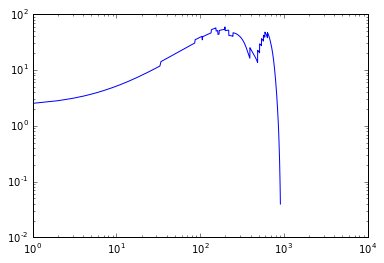

In [38]:
plt.loglog(flux[:10000,2])

In [4]:
#large one...
L=1000

nc=np.linspace(0,150,31)
flux=np.zeros((5000*31*32/2,3))
c=0
for i in range(0,1):
    for k in range(len(nc)):
        sc=np.linspace(0,nc[k],nc[k]/5+1)

        for j in range(len(sc)):
            #print(i)
            mv=[]
        #flowc=int(dens*L)
        #print(flowc)
            my_ants=ants(num_ants=int(nc[k]),flowc=int(nc[k]-sc[j]),stoppedc=int(sc[j]),politeness=1)
        
            flux,c=run(flux,c)
        #print(i,j)
        #phi_a[k,i,j]=dens*mv[-1]
        #vel_a[k,i,j]=mv[-1]
            print(k,j)


/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/svivek/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/svivek/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 0
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
5 5
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
15 14
15 15
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14
18 15
18 16
18 17
18 18
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 1

In [5]:
sio.savemat("flux-500m-hacked-IDM-p1.mat",{'flux':flux})

    

In [67]:
#hacking after 1000 timesteps
""" Imports. matplotlib and cv2 for visualization, numpy and random for the engine, scipy for analysis"""

#import numpy as np
#from matplotlib import pyplot as plt
#import cv2
#import random
#from matplotlib import animation
#from matplotlib.animation import FuncAnimation
#%matplotlib inline
#from scipy.optimize import curve_fit
#import matplotlib.pylab as pylab
L=1000

#define function for periodic boundary conditions
def pb(x0,L):
	return((x0+L)%L)


#Define the ant class
class ant():
    """Ant class defines how individual cars will behave. There are several attributes and methods:
        
        attributes:
            x = position on road of length L (initialized to a random number)
            y = which lane (e.g. for three lane simulation y = 0, 1, or 2)
            xunp = total distance traveled (useful for generating space-time plots)
            v = current velocity of the car (initialized to a small random value)
            v_pref = preferred velocity of a car (on average this will be 29 m/s or ~65 mph)
            R = distance corresponding to "two second rule". At separations less than R, cars don't feel each other
            r = size of a car
            ids = an i.d. number for the car
            stopped = a boolean to determine whether the car is "broken down" or behaving normally
            idm = an option to model the car's behavior using the Intelligent Driver Model (see wikipedia)
            idmT, idmA, idmB, idmDelta = parameters for the intelligent driver model
            flowc = a parameter that can set cars to 'stopped'
            dt = the size of a simulation time-step
            
        methods:
            step(d, vbar, counter, delV):
                this method evolves the car by one time-step. updates vbar, xunp, and x.
                Inputs are...
                d = distance to next car
                delV = speed difference between this car and car in front of it
                counter = just a counter to keep track of how many timesteps have elapsed
                vbar = the average velocity of all cars in the simulation. During this car's
                    update, the average velocity of all cars will be updated
            force(x, delV):
                this method computes the current force on the car, passes output to step()
                Inputs are...
                x = distance to next car
                delV = speed difference w/r/t next car
                
    """
    
    def __init__(self,ids,y=0,flowc=0,stoppedc=0,cari=0):
        col=['ro','bo','go']
        self.x=np.random.uniform(0,L)
        self.y=y
        self.xunp=self.x
        self.v=np.random.uniform(0,1)
        #self.tau=.1
        self.dt=.1
        self.v_pref=33.33#+np.random.normal(0,6.7/2)
        #self.R=29*2
        self.r=5
        self.ids=ids
        self.idmT=1.6
        self.idmA=0.73
        self.idmB=1.67
        self.idmDelta=4
        self.stopped=0
        self.laneint=col[y]
        #print(cari)
        if (cari>=flowc):   
            #print(cari)
            self.v_pref=33.33  
            self.v=np.random.uniform(0,1)
            self.stopped=1
                #print(stoppedc)

              
    def step(self,d=None,vbar=0,counter=0,delV=0):
        if d==None:
            self.xunp=self.xunp+self.dt*self.v
            self.x=pb(self.x+self.dt*self.v,L)
            return('same')
        else:
            if d<=0:
                f=0
            else:
                #if d<self.R:
                    #ep=((self.v_pref)/self.tau)*(1-(self.r/self.R))**(-1.5)
                f=self.force(d,delV)
                #else:
                #    f=0
        x0=self.x
        self.v=max(0,self.v+self.dt*f)
        counter+=1 
        vbar=((counter-1)*vbar+self.v)/counter
        self.xunp=self.xunp+self.dt*self.v
        self.x=pb(self.x+self.dt*self.v,L)
        return(vbar,counter)
    def force(self,x,delV=0):
        if self.v_pref==0:
            return(0)
        s_star=2+max(0,self.idmT*self.v+(self.v*delV)/((self.idmA*self.idmB)**.5))
        f=self.idmA*(1-(self.v/self.v_pref)**self.idmDelta-(s_star/(x-self.r))**2)
        return(f)
        
        if type(f)!=complex:
            return(f)
        else:
            return(0)

        
class ants():
    def __init__(self,num_ants=20,lanes=3,L=1000,flowc=0,stoppedc=0,politeness=1):
        self.lanes=lanes
        self.num_ants=num_ants
        #self.stopped=stoppedc
        self.members=[[] for i in range(lanes)]
        self.state=[[] for i in range(lanes)]
        self.vel=[[] for i in range(lanes)]
        self.ids=[[] for i in range(lanes)]
        self.xunp=[[] for i in range(lanes)]
        self.stopped=[[] for i in range(lanes)]
        self.laneint=[[] for i in range(lanes)]
        self.L=L
        self.p=politeness
        #self.idm=idm
        cari=0
        #meanvel=0
        for l in range(lanes):
            self.members[l]=[ant(ids=i,y=l,flowc=flowc,stoppedc=stoppedc,cari=i) for i in range(num_ants)]
            self.state[l]=np.array([bug.x for bug in self.members[l]])
            self.xunp[l]=np.array([bug.xunp for bug in self.members[l]])
            self.vel[l]=np.array([bug.v for bug in self.members[l]])
            self.stopped[l]=np.array([bug.stopped for bug in self.members[l]])
            self.ids[l]=np.array([i for i in range(num_ants)])
            self.members[l]=sorted(self.members[l], key=lambda bug: bug.x)
            self.laneint[l]=np.array([bug.laneint for bug in self.members[l]])
            self.counter=0
            self.vbar=0
            
            
    def step(self,t):
        meanvel=0
        to_switch=[[] for i in range(self.lanes)]
        for l in range(self.lanes):
        #l=np.random.choice([0,1,2])
        #a1=np.arange(len(self.members[l]))
        #random.shuffle(a1)
        
            for i in range(len(self.members[l])):
                bug=self.members[l][i]
                switchQ=False
                #if (bug.stopped
                if bug.y==0:
                    if random.random()>.5:
                        switchQ=self.change_lanesQ(0,1,bug,i,t)
                    if switchQ:
                        to_switch[1].append(bug)
                elif bug.y==1:
                    lane_to_try=np.random.choice([0,2])
                    switchQ=self.change_lanesQ(1,lane_to_try,bug,i,t)
                    #switchQ=self.change_lanesQ(1,0,bug,a1[i])
                    if(switchQ):
                        to_switch[lane_to_try].append(bug)
                else:
                    if random.random()>.5:
                        switchQ=self.change_lanesQ(2,1,bug,i,t)
                    if switchQ:
                        to_switch[1].append(bug)
            
                x_b=pb(bug.x,self.L); v_b=bug.v
                x_ol=pb(self.members[l][pb(i+1,len(self.members[l]))].x,self.L)
                v_ol=self.members[l][pb(i+1,len(self.members[l]))].v
                dx_b=min(abs(x_ol-x_b),self.L-abs(x_ol-x_b))
                delV_b=-v_ol+v_b                
                if((dx_b>7) and (bug.stopped==0)):
                    self.vbar,self.counter=bug.step(dx_b,self.vbar,self.counter,delV=delV_b)
                elif ((dx_b>7) and (t<1000) and (bug.stopped==1)):
                    #bug.v_pref=33.33
                    self.vbar,self.counter=bug.step(dx_b,self.vbar,self.counter,delV=delV_b)
                else:
                #
                    bug.v=0

                    
                    
        for l in range(self.lanes):
            for bug in to_switch[l]:
                self.members[l].append(bug)
                self.members[bug.y].remove(bug)
                bug.y=l
        for l in range(self.lanes):
                
            self.members[l]=sorted(self.members[l],key=lambda y: y.x)
            self.state[l]=np.array([bug.x for bug in self.members[l]])
            self.xunp[l]=np.array([bug.xunp for bug in self.members[l]])
            self.vel[l]=np.array([bug.v for bug in self.members[l]])
            self.ids[l]=np.array([bug.ids for bug in self.members[l]])
            self.stopped[l]=np.array([bug.stopped for bug in self.members[l]])
            meanvel=meanvel+np.mean(self.vel[l])
            
        meanvel=meanvel/3
 
        return(meanvel)
												
    def change_lanesQ(self,current_lane,new_lane,bug,i,t):
        #if ((bug.stopped==1)):
        #    return(False)
        #if(len(self.members[new_lane]>1) and len(self.members[new_lane]>1))
        nf_index=self.find_neighbor(bug,new_lane) 
        x_b=pb(bug.x,self.L)
        v_b=bug.v
        x_nl=pb(self.members[new_lane][pb(nf_index+1,len(self.members[new_lane]))].x,self.L)
        v_nl=self.members[new_lane][pb(nf_index+1,len(self.members[new_lane]))].v
        x_nf=pb(self.members[new_lane][nf_index].x,self.L)
        v_nf=self.members[new_lane][nf_index].v
        x_ol=pb(self.members[current_lane][pb(i+1,len(self.members[current_lane]))].x,self.L)
        v_ol=self.members[current_lane][pb(i+1,len(self.members[current_lane]))].v
        x_of=pb(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].x,self.L)
        v_of=self.members[current_lane][pb(i-1,len(self.members[current_lane]))].v

        #2) get relevant dx values
        #    a) get the current values
        dx_nf=min(abs(x_nl-x_nf),self.L-abs(x_nl-x_nf))
        dx_b=min(abs(x_ol-x_b),self.L-abs(x_ol-x_b))
        dx_of=min(abs(x_b-x_of),self.L-abs(x_b-x_of))
        #    b) get the values after the lane switch
        dx_bp=min(abs(x_nl-x_b),self.L-abs(x_nl-x_b))
        dx_nfp=min(abs(x_b-x_nf),self.L-abs(x_b-x_nf))
        dx_ofp=min(abs(x_ol-x_of),self.L-abs(x_ol-x_of))
        
        #get relevant delv values
        dv_nf=-v_nl+v_nf
        dv_b=-v_ol+v_b
        dv_of=-v_b+v_of
        
        dv_bp=-v_nl+v_b
        dv_nfp=-v_b+v_nf
        dv_ofp=-v_ol+v_of
        
        #3) get relevant forces
        f_current=[bug.force(dx_b,dv_b)]
        f_current.append(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].force(dx_of,dv_of))
        f_current.append(self.members[new_lane][nf_index].force(dx_nf,dv_nf))
        
        f_new=[bug.force(dx_bp,dv_bp)]
        f_new.append(self.members[new_lane][nf_index].force(dx_nfp,dv_nfp))
        f_new.append(self.members[current_lane][pb(i-1,len(self.members[current_lane]))].force(dx_ofp,dv_ofp))
        if ((f_current[0]+self.p*(f_current[1]+f_current[2])<1*(f_new[0]+self.p*(f_new[1]+f_new[2]))) and \
            (bug.stopped==0) and (dx_nfp>7) and (dx_bp>7)):
            return(True)
        elif ((f_current[0]+self.p*(f_current[1]+f_current[2])<1*(f_new[0]+self.p*(f_new[1]+f_new[2]))) and \
            (bug.stopped==1) and (t<1000) and (dx_nfp>7) and (dx_bp>7)):
            return(True)
        return(False)
								
    def view(self,t):
        fig=plt.figure()
        plt.xlim(-1,self.L+1)
        plt.ylim(-1,2)
        line1, =plt.plot(np.arange(self.L),np.zeros(self.L),'k')
        a1='ro'
        #line2, =plt.plot([b.x for b in self.members[0]],np.zeros(len(self.members[0])),'ro')            
        line3, =plt.plot(np.arange(self.L),.5*np.ones(self.L),'k')
        #line4, =plt.plot([b.x for b in self.members[1]],.5*np.ones(len(self.members[1])),'bo')
        line5, =plt.plot(np.arange(self.L),np.ones(self.L),'k')
        #line6, =plt.plot([b.x for b in self.members[2]],np.ones(len(self.members[2])),'go')
        for l in range(0,3):
            for b in self.members[l]:
                plt.plot(b.x,np.array([1])*.5*l,b.laneint)
                if(b.stopped==1):
                    plt.plot(b.x,np.array([1])*.5*l,'ko')
        
        
        fig.savefig('./images/graph'+str(t)+'.png') #save figures
        plt.close(fig)
        
    def find_neighbor(self,bug,new_lane):
        x=0;i=0
        while(x<bug.x):
            try:
                x=self.members[new_lane][i].x
            except IndexError:
                return(i-1)
            i+=1
        return(i-2)
        
    def video(self,n_steps=20):
        fig=plt.figure(figsize=(10,3))
        plt.xlim(-1,self.L+1)
        plt.ylim(-2,2)
        line1, =plt.plot(np.arange(self.L),np.zeros(self.L),'k')
        line2, =plt.plot([b.x for b in self.members[0]],np.zeros(len(self.members[0])),'ro')
        line3, =plt.plot(np.arange(self.L),np.ones(self.L),'k')
        line4, =plt.plot([b.x for b in self.members[1]],np.ones(len(self.members[1])),'bo')
        line5, =plt.plot(np.arange(self.L),-np.ones(self.L),'k')
        line6, =plt.plot([b.x for b in self.members[0]],-np.ones(len(self.members[0])),'go')
        while(True):
            for i in range(n_steps):
                self.step()
            line2.set_xdata([b.x for b in self.members[0]])
            line2.set_ydata(np.zeros(len(self.members[0])))
            line4.set_xdata([b.x for b in self.members[1]])
            line4.set_ydata(np.ones(len(self.members[1])))
            line6.set_xdata([b.x for b in self.members[2]])
            line6.set_ydata([-np.ones(len(self.members[2]))])
            fig.canvas.draw()
            img=np.fromstring(fig.canvas.tostring_rgb(),dtype=np.uint8,sep='')
            img=img.reshape(fig.canvas.get_width_height()[::-1]+(3,))
            img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
            cv2.imshow('ants',img)
            if cv2.waitKey(20)==27:
                break
        cv2.destroyWindow('ants')


#%%
def run(flux,c):

#	print(nc[k],ac[j])
#dens2=np.zeros(10000)
#phi2=np.zeros(10000)
	for t in range(10000):
		d1=0
		f1=0
		av1=0
		meanv=my_ants.step(t)
		if (t>=5000):
			p=my_ants.state
			p=np.r_[p[0],p[1],p[2]]
			v=my_ants.vel                
			v=np.r_[v[0],v[1],v[2]]
			stop=my_ants.stopped                
			stop=np.r_[stop[0],stop[1],stop[2]]
			w=np.where((p>250) & (p<750))[0]   
			d1=d1+len(w)                
			f1=f1+np.sum(v[w])  
#				print(len(v),len(stop),len(w))
			av1=av1+np.sum(stop[w]) 
#			a1=np.c_[int(d1*2/3),int(av1*2/3),f1*2/3]
#			print(a1)
			flux[c,:]=np.c_[int(d1*2/3),int(av1*2/3),f1*2/3]
			c=c+1
    #			print(np.shape(flux))
#			my_ants.view(t)
#		if (t%100==0):
#			my_ants.view(t)        
#			w=np.where(my_ants.state<300)[0]           
#			a1=np.c_[nc[k],ac[j],np.mean(meanv)*nc[k]]
#			print(a1)
#			flux=np.r_[flux,a1]

#		w=np.where((my_ants.state>500) &(my_ants.state<1000))[0]
#		dens2[t]=len(w)/500*1000
#		if t%1000==0:
#			print(t)
	return (flux,c)




In [65]:
#test one...
L=1000

nc=np.linspace(30,30,1)
flux=np.zeros((5000*31*32/2,3))
c=0
for i in range(0,1):
    for k in range(len(nc)):
        sc=np.linspace(15,15,1)

        for j in range(len(sc)):
            #print(i)
            mv=[]
        #flowc=int(dens*L)
        #print(flowc)
            my_ants=ants(num_ants=int(nc[k]),flowc=int(nc[k]-sc[j]),stoppedc=int(sc[j]),politeness=1)
        
            flux,c=run(flux,c)
        #print(i,j)
        #phi_a[k,i,j]=dens*mv[-1]
        #vel_a[k,i,j]=mv[-1]
            print(k,j)


/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0 0


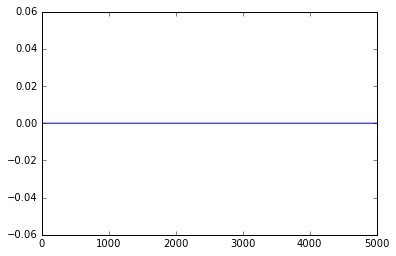

In [39]:
plt.plot(flux[:5000,2])

In [68]:
#large one...
L=1000

nc=np.linspace(0,150,31)
flux=np.zeros((5000*31*32/2,3))
c=0
for i in range(0,1):
    for k in range(len(nc)):
        sc=np.linspace(0,nc[k],nc[k]/5+1)

        for j in range(len(sc)):
            #print(i)
            mv=[]
        #flowc=int(dens*L)
        #print(flowc)
            my_ants=ants(num_ants=int(nc[k]),flowc=int(nc[k]-sc[j]),stoppedc=int(sc[j]),politeness=1)
        
            flux,c=run(flux,c)
        #print(i,j)
        #phi_a[k,i,j]=dens*mv[-1]
        #vel_a[k,i,j]=mv[-1]
            print(k,j)


/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/svivek/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/svivek/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 0
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
5 5
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
15 14
15 15
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14
18 15
18 16
18 17
18 18
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 1

In [69]:
sio.savemat("flux-500m-hacked-IDM-p1-run1000.mat",{'flux':flux})

    

In [52]:
len(my_ants.members[0])

4